In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import erfc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import seaborn as sns
from scipy.special import expit
import csv
import pandas as pd

In [2]:
# Definition of several utility functions.
def modulate(bits, modtype):
    if(modtype==2):
        symbols_bpsk = [-1.0 + 1j*0.0, 1.0 + 1j*0.0]
        ip = symbols_bpsk[bits]
        # Normalization of energy to 1.
        symbol = (1.0/np.sqrt(1.0))*ip
    elif(modtype==4):
        symbols_qpsk = [-1.0 - 1j*1.0, -1.0 + 1j*1.0, 1.0 - 1j*1.0, 1.0 + 1j*1.0]
        ip = symbols_qpsk[bits]
        # Normalization of energy to 1.
        symbol = (1.0/np.sqrt(2.0))*ip
    elif(modtype==16):
        symbols_16qam = [-3.0 - 1j*3.0, -3.0 - 1j*1.0, -3.0 + 1j*3.0, -3.0 + 1j*1.0, 
                         -1.0 - 1j*3.0, -1.0 - 1j*1.0, -1.0 + 1j*3.0, -1.0 + 1j*1.0, 
                         +3.0 - 1j*3.0, +3.0 - 1j*1.0, +3.0 + 1j*3.0, +3.0 + 1j*1.0,
                         +1.0 - 1j*3.0, +1.0 - 1j*1.0, +1.0 + 1j*3.0, +1.0 + 1j*1.0
                        ]
        ip = symbols_16qam[bits]
        # Normalization of energy to 1.
        symbol = (1.0/np.sqrt(10.0))*ip
    else:
        print('Error: Modulation not implemented.')
        
    return symbol

class LogisticRegressor:
    
    def __init__(self, seed=42):
        self.seed = seed

    def error_function(self, x, y, a):
        h = expit(x.dot(a))
        error = -(1/len(y))*np.sum(y.T.dot(np.log(h)) + (1-y).T.dot(np.log((1-h) )))
        return error

    def predict(self, x, a):
        h = expit(x.dot(a))
        c = np.zeros((len(h), 1))
        for i in range(0, len(h)):
            if(h[i] >= 0.5):
                c[i,0] = 1.0
        return c
    
    def predict_proba(self, x, a):
        h = expit(x.dot(a))
        return h

    def predict_proba2(self, x, a):
        h1 = expit(x.dot(a))
        h0 = 1 - h1
        h = np.c_[h0, h1]
        return h
    
    def fit(self, x_train, y_train, x_test, y_test, alpha, n_iterations):
        # Random initialization of parameters.
        random.seed(self.seed)
        a = np.random.randn(x_train.shape[1], 1)

        # Create array for storing error values.
        Jgd = np.zeros(n_iterations+1)
        Jgd_v = np.zeros(n_iterations+1)

        # Calculate initial error.
        Jgd[0] = self.error_function(x_train, y_train, a)
        Jgd_v[0] = self.error_function(x_test, y_test, a)

        # Batch gradient-descent loop.
        minimum_val_error = float("inf")
        error = float("inf")
        iteration = 0
        while iteration < n_iterations:
            gradients = -1/len(y_train)*x_train.T.dot(y_train - expit(x_train.dot(a)) )
            a = a - alpha * gradients
            Jgd[iteration+1] = self.error_function(x_train, y_train, a)
            Jgd_v[iteration+1] = self.error_function(x_test, y_test, a)
            error = np.abs(Jgd[iteration+1] - Jgd[iteration])
            # Store weights for the smallest error ever.
            if(Jgd_v[iteration+1] < minimum_val_error):
                minimum_val_error = Jgd_v[iteration+1]
                a_min = a        
            iteration += 1
        return a_min, minimum_val_error, iteration, Jgd, Jgd_v

def createCSVFile(I, Q, mod, N, filename):
    f = open(filename, 'w', newline='')
    writer = csv.writer(f, delimiter=',')
    for i in range(0,N):
        writer.writerow((I[i][0], Q[i][0], mod[i]))
    f.close()
    
def readCSVFile(filename):
    df = pd.read_csv(filename, header=None)

    i = df[0].to_numpy()
    q = df[1].to_numpy()
    mod = df[2].to_numpy()

    i = i.reshape(len(i),1)
    q = q.reshape(len(q),1)
    mod = mod.reshape(len(mod),)
    
    return i, q, mod

In [3]:
# Number of symbols to be transmitted.
N = 1000

# Create Es/N0 vector.
EsN0dB = 15
EsN0Lin = 10.0**(-(EsN0dB/10.0))

# Number of classes.
C = 2

# Generate random modulations.
mod = np.random.randint(0, C, (N,))

y = np.zeros((N, 1), dtype=complex)
for i in range(0, N):
    
    if(mod[i] == 0):
        # Generate BPSK symbols.
        bit_bpsk = np.random.randint(0, 2)
        # Modulate the binary stream into BPSK symbols.
        symbol = modulate(bit_bpsk, 2)
    elif(mod[i] == 1):
        # Generate QPSK symbols.
        bit_qpsk = np.random.randint(0, 4)
        # Modulate the binary stream into QPSK symbols.
        symbol = modulate(bit_qpsk, 4)
    else:
        # Generate 16QAM symbols.
        bit_16qam = np.random.randint(0, 16)
        # Modulate the binary stream into 16QAM symbols.
        symbol = modulate(bit_16qam, 16)        
        
    # Pass QPSK symbols through AWGN channel.
    noise = np.sqrt(EsN0Lin/2.0)*(np.random.randn() + 1j*np.random.randn())    
    y[i] = symbol + noise

In [4]:
filename = './modulations.csv'

createCSVFile(np.real(y), np.imag(y), mod.ravel(), N, filename)

I, Q, mod = readCSVFile(filename)

y = I + 1j*Q

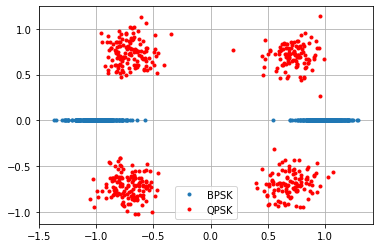

In [5]:
if(C >= 1):
    idx0 = np.argwhere(mod == 0)
    plt.plot(np.real(y[idx0.ravel()]), np.zeros((len(idx0),1)), '.', label='BPSK')
if(C >= 2):
    idx1 = np.argwhere(mod == 1)
    plt.plot(np.real(y[idx1.ravel()]), np.imag(y[idx1.ravel()]), 'r.', label='QPSK')
if(C >= 3):
    idx2 = np.argwhere(mod == 2)
    plt.plot(np.real(y[idx2.ravel()]), np.imag(y[idx2.ravel()]), 'k.', label='16QAM')

plt.grid()
plt.legend()
plt.show()

In [6]:
seed = 42

X = np.c_[np.ones((N, 1)), np.real(y)**2, np.imag(y)**2]

modd = mod.reshape(N,1)/1.0

x_train, x_test, y_train, y_test = train_test_split(X, modd, test_size=0.3, random_state=seed)

# Train the model.
alpha = 0.3
n_iterations = 50000

# Instantiate Logistic classifier.
clf = LogisticRegressor(seed)
a_min, minimum_val_error, iteration, Jgd, Jgd_v = clf.fit(x_train, y_train, x_test, y_test, alpha, n_iterations)

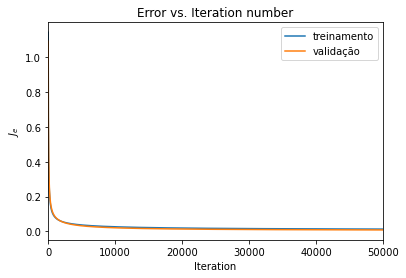

In [7]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

In [8]:
y_pred = clf.predict(X, a_min)

In [9]:
# Calculate accuracy of class predictions.
accuracy_score(mod, y_pred)

0.998

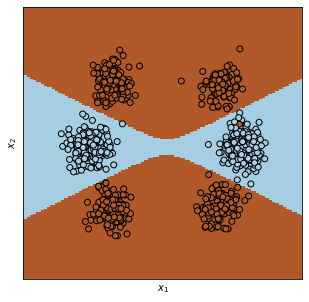

In [10]:
X = np.c_[np.ones((N, 1)), np.real(y), np.imag(y)]

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 1].min() - .5, X[:, 1].max() + .5
y_min, y_max = X[:, 2].min() - .5, X[:, 2].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel()**2, yy.ravel()**2], a_min)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(5, 5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 1], X[:, 2], c=mod, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

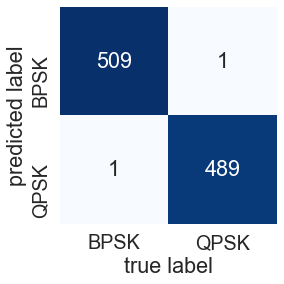

In [11]:
# Plot the confusion matrix
mat = confusion_matrix(mod, y_pred)
sns.set(font_scale=1.8)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['BPSK','QPSK'], yticklabels=['BPSK','QPSK'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

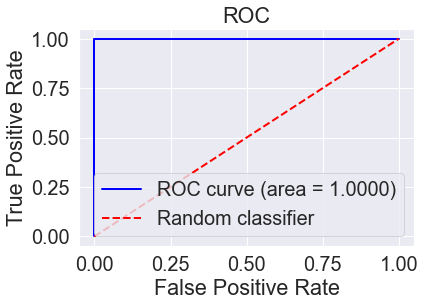

In [12]:
# Getting the probabilities for each class.
y_prob = clf.predict_proba(x_test, a_min)
# Calculating ROC curve and ROC AUC.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
# Plotting ROC curve.
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=lw, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [13]:
y_pred = clf.predict(x_test, a_min)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       149
         1.0       0.99      1.00      1.00       151

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

